In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import json
from math import pi
from scipy.signal import upfirdn
warnings.filterwarnings('ignore')

# USER TRANSMITTER 

The first thing that we need to do is to load the file with the settings. These all all gthe parameters that we are going to use for the development of the project.

In [69]:
f = open('settings.ini')
settings = json.load(f)
 
for i in settings:
    print(i, end=': ')
    print(settings[i])
    
f.close()

#the transmitted power is in W, while the transmitter and receiver gains are in dB

fSampling: 4092000.0
quantizationBits: 16
scenarioDuration: 5.05
SV_PRN_ID: 1
CRCpolynomial: A23DCB
SYNCpattern: 0101100000
TAILpattern: 000000
SVIDlength: 6
MIDlength: 4
MBODYlength_TX: 80
MBODYlength_ACK: 30
CRClength: 24
nPRN_x_Symbol: 1
nChip_x_PRN: 4092
chipRate: 1023000.0
bitRate: 250
maxDoppler: 100000.0
transmitterGain: 30
receiverGain: 15
transmittedPower: 27


### Loading the Galileo E1 PRNs
In order to generate the signal, we need first of all to load the pseudo random noise sequences.

There exist two different kinds of PRN codes for Galileo E1: E1B and E1C.
They are contained, in hexadecimal format, in the files called repectively "E1B - Gal.txt" and "E1C - Gal.txt"

For this simulation, we only consider the E1B PRNs:

In [70]:
filename = "E1B - Gal.txt"

# defining the name of the column of the dataframe called e1b
columns = ["Hexadecimal"]

#reading the file
e1b = pd.read_table(filename, sep='\n', header=None, names=columns)

# deleting the first 15 characters (not part of the code)
e1b['Hexadecimal'] = [el[16::] for el in e1b['Hexadecimal']]

# creating a new column with the codes indexes and placing it as first column
e1b['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1b = e1b.reindex(columns=column_list)

# printing the first lines of the dataframe
e1b.head()

,Code index,Hexadecimal
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...


In [71]:
# last code (just to verify if the loading operation is correct)
print(e1b['Hexadecimal'][49])

97051FC67ACA30E8AEE73D3A8CF38BB13524D4E0EBD9BE68398C7C16227CABB1D0B0A0ABE7B6384ABA02905BA0C3C7363599D059C7B4C99DB165CD14FA12FA7912449CA7DD5E346D8010C85A757382270DAD15BA3CE36A76EF55F81A1E80BF366B37FE3A88EC722028C25E234E624040450A99CD808F942568AA7133981D72E7F2928894670AD5399482DF1B90E7E64062F830B736C79C30F36281495C76699CD48404673FA334F042F9E0E67DD7F3853BF71ABEAF6A9A5546855E840CE42B224D8F6490C6CE5FC02EBAF4FFC390107058F54CD635D4A7F2878099C1EF495750E6921BE2F39AD808C4210F287319F811A254CEF8CF153FC50AB2F3D694A530949E5F578D075DB96DDCF2BB90ED3DE09D9CA8E08662FD8982741DE1CE0A6B64C3D3D5004B5C04B2B0DFD976A20FACC94D1762D41EE03B40D2CF367612812EF4CC41D1BFE9CEB51AE3A22AF1BE7B85A057D3048D0E73FA0FDAF1119EFD76F0A41BE63128B22D64A5553E9549D411483BBCA1483EF30CF6A6D317AD2C7973EFA6D4C1121F703D2F48FCDA3177AD450D75D2A28D2C244AEA13F0E60AEED8ACBAB444D400DF5E280DB799B2D9A984DF1E2567D39D1DE58EF78CA6B4D8BC172B07DCB02D156CA96EEFAC69E556CFCE0AAB617C7FBB8C34871C1D35E74B7BD307D3F2E424C7A9AD676A1A69E0FE735EA50887A1DFAE6CA2

In [72]:
# simple conversion from hexadecimal to binary
def hex2bin(h):
    integer = int(h, 16)
    binary = bin(integer)[2::]     #discarding the first two elements (i.e. 0b, not needed)
    binary = np.array([int(x) for x in binary])    #the binary representation is a numpy array of integers
    return binary
    
# creation of a new column of the dataframe with the binary representation of each PRN
e1b['Binary'] = e1b['Hexadecimal'].apply(hex2bin)

#creation of a copy of the dataframe to use without modifying the original dataframe
e1bcopy = e1b.copy()
e1b

,Code index,Hexadecimal,Binary
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ..."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."


In [73]:
print(e1b['Binary'][49])    # to verify if the conversion was successful, we print the last code in binary:

# since the last code starts with 9 7 ... in hexadecimal, the binary representation should start with 
# 1001 0111 ...
# and since it ends with ... 2 0, the binary representation should end with
# ... 0010 0000

[1 0 0 ... 0 0 0]


## MODULATION

The signal sent by Galileo is supposed to be modulated with a Binary Offset Carrier modulation. In particular, the one that is used for Galileo E1 signal is the BOC(1,1) modulation, that utilizes a Non-return to zero square subcarrier with a period Tp equal to the chip rate Tc.

In order to generate the BOC(1,1) signal we need to modify the codes. Indeed, the sequence to modulate with the BOC(1,1) square subcarrier is obtained by applying a XOR between the data message and the PRN. Alternatively, obtaining the same result, it is possible to convert the binary sequences (both the data message and the PRNs) by considering a -1 instead of a 1 and by considering a 1 instead of a 0.

So the sequence 0 1 1 1 0 becomes 1 -1 -1 -1 1 (this is valid for both the data message and the PRN). Then instead of applying a XOR we can simply multiply the data message and the PRN, the final result is the same.

Indeed, by converting 0 in 1 and 1 in -1 we get:

|  | BIT 1 | BIT 2 | XOR | CONVERSION |
| :-: | :-: | :-: | :-: | :-: |
| 1) | 0 | 0 | 0 | 1 |
| 2) | 0 | 1 | 1 | -1 |
| 3) | 1 | 0 | 1 | -1 |
| 4) | 1 | 1 | 0 | 1 |

that is the same we get with the product after the conversion:

| | BIT 1 | BIT 2 | PRODUCT 
| :-: | :-: | :-: | :-: |
| 1) | 1 | 1 | 1 |
| 2) | 1 | -1 | -1 |
| 3) | -1 | 1 | -1 |
| 4) | -1 | -1 | 1 |

Therefore now we create another dataframe where we store the modified PRNs.

In [74]:
def conversion(prn):
    new_prn = np.zeros(len(prn))
    for i in range(len(prn)):
        if prn[i] == 0:
            new_prn[i] = 1
        elif prn[i] == 1:
            new_prn[i] = -1
    return np.array(new_prn, int)   # the prns are stored in a numpy array of integers

e1bmodified = e1b.copy()
e1bmodified['Modified'] = e1bmodified['Binary'].apply(conversion)

e1bmodifiedcopy = e1bmodified.copy()
e1bmodified

,Code index,Hexadecimal,Binary,Modified
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[-1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[-1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1,..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...","[-1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1,..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...","[-1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, ..."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ...","[-1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, ..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...","[-1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1,..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...","[-1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1,..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...","[-1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1..."


## Visualization of PRNs in time domain

Now that the PRNs have been loaded, it is possible to visualize the first samples of them. This is done by using two functions defined below.

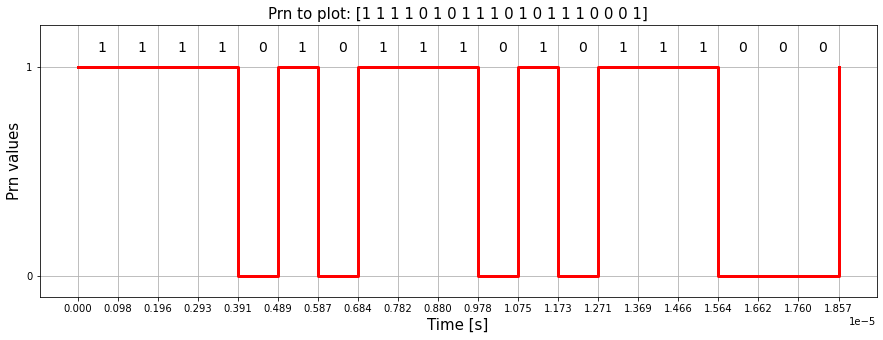

In [75]:
#this function plots the original PRNs

def plot_prn_zeros(N, prn, Rc):
    
    Tc = 1 / Rc     # chip period 
    
    t = np.arange(0, N*Tc, Tc)
    
    xticks = t
    yticks = [0, 1]
    centers = 0.5*(xticks[1:] + xticks[:-1]) 
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(t, prn[0:N], where='post', color='red', lw=3)
    ax.set_xticks(t)
    ax.set_yticks(yticks)
    title = "Prn to plot: " + str(prn[0:N])
    ax.set_title(title, fontsize = 15)
    ax.set_ylim(-0.1,1.2)
    ax.set_xlabel("Time [s]", fontsize=15)
    ax.set_ylabel("Prn values", fontsize=15)
    ax.grid()
    for i,j in zip(centers, prn[0:N]):
        ax.text(i, 1.07, j, fontsize=14)   
        
plot_prn_zeros(20, e1bcopy['Binary'][0], settings['chipRate'])

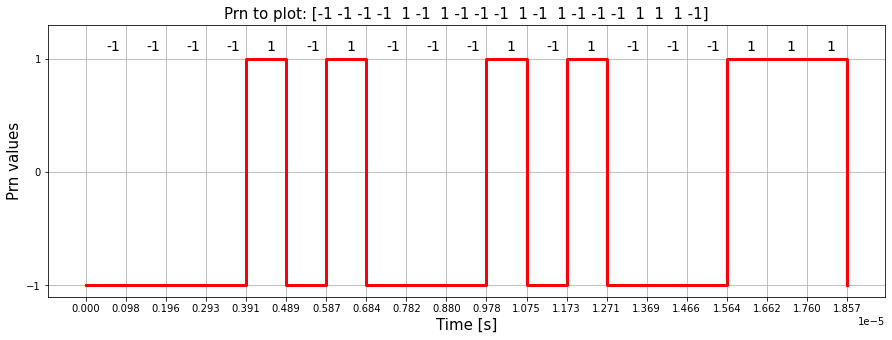

In [76]:
#this function plots the modified prns 

def plot_prn_modified(N, prn, Rc):
    
    Tc = 1 / Rc     # chip period 
    
    t = np.arange(0, N*Tc, Tc)
         
    xticks = t
    yticks = [-1, 0, 1]
    centers = 0.5*(xticks[1:] + xticks[:-1]) 
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(t, prn[0:N], where='post', color='red', lw=3)
    ax.set_xticks(t)
    ax.set_yticks(yticks)
    title = "Prn to plot: " + str(prn[0:N])
    ax.set_title(title, fontsize=15)
    ax.set_ylim(-1.1,1.3)
    ax.set_xlabel("Time [s]", fontsize=15)
    ax.set_ylabel("Prn values", fontsize=15)
    ax.grid()
    for i,j in zip(centers, prn[0:N]):
        ax.text(i, 1.07, j, fontsize=14)   

plot_prn_modified(20, e1bmodifiedcopy['Modified'][0], settings['chipRate'])

## BOC(1,1) MODULATION

The BOC(1,1) modulation is obtained by multiplying 4 components:
- the data message we need to transmit (given by a sequence of symbols with symbol period Tb);
- the PRN sequence we use to spread the data message (given by a sequence of chips with chip period Tc);
- a square wave subcarrier with period Tp = Tc (due to n = m = 1)
- a sinusoidal carrier 

Since for this project the I/Q samples must be generated in baseband, the multiplication by the sinusoidal carrier is not needed.

In [77]:
# HERE WE NEED TO INSERT OUR REAL MESSAGE TO TRANSMIT

In [78]:
#first we generate a random binary message of 80 bits (so it contains only zeros and ones)
message_len = 80
message = np.random.randint(0,2,message_len)
        
print("Data message:\n", message)

Data message:
 [0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1
 0 0 1 0 1 0]


Subcarrier length: 654720
[ 1 -1  1 ... -1  1 -1]


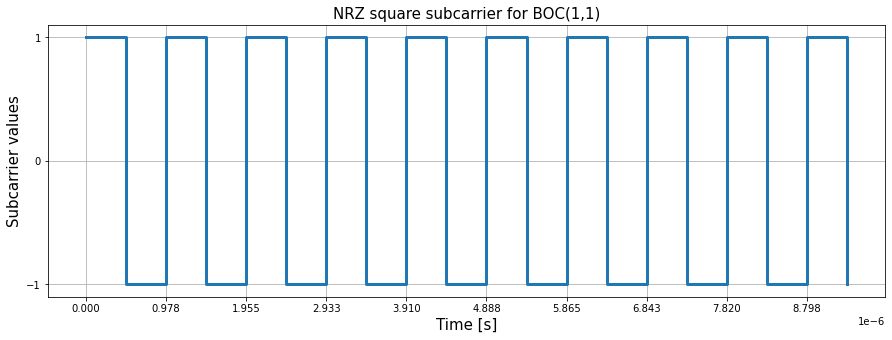

In [79]:


#Now we generate the BOC subcarrier, that is a square NRZ wave. The period of the waveform is given by Tc
#The needed length of the subcarrier is 654720. This will be clarified later, but basically the spreaded sequence
#is composed of 327360 symbols (data message is 80 symbols, and each symbol is spreaded with a PRN, that has 4092
#chips, so 80*4092 = 327360) and each symbol of the spreaded sequence is kept constant for 2 samples of the 
#subcarrier, therefore 327360*2 = 654720.

Rc = 1.023e06   # chip rate
Tc = 1 / Rc     # chip period 

rep = 2 
s = np.array([1, -1])
subcarrier = np.tile(s, 327360) # we repeat the values 1 and -1 for 327360 times in order to have an array of 654720 elements
                             

#now we plot the first 20 samples of the subcarrier
xticks = np.arange(0,10*Tc, Tc)
yticks = [-1, 0, 1]

t = np.arange(0, 10*Tc, Tc/2)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.step(t, subcarrier[0:20], where='post', lw=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_title('NRZ square subcarrier for BOC(1,1)', fontsize=15)
ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel('Subcarrier values', fontsize=15)
ax.grid()

print("Subcarrier length:", len(subcarrier))  
print(subcarrier)

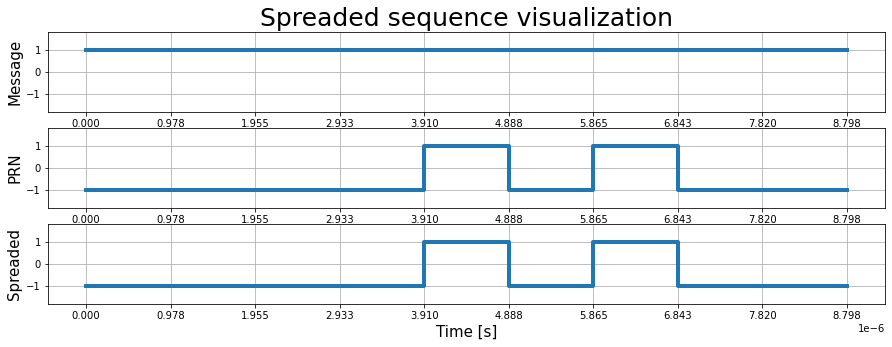

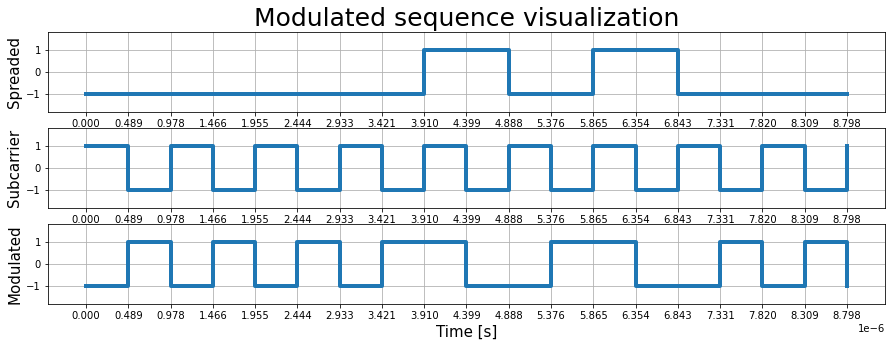


Modulated message:
 [-1.  1. -1. ...  1.  1. -1.]


In [80]:
#now we have the data message, the subcarrier and the prn can be retrieved from the dataframe
#we can create a function that does the modulation and (if flag = True) plots the signals

#Input: the data message (80 bits), the subcarrier (654720 samples), the bit rate, the chip rate and the index of the PRN (4092 chips) to use,
#       that goes from 1 to 50 (while the prn index goes from 0 to 49) and a flag, to visualize it or not
#Output: the modulated signal

def boc(message, subcarrier, Rb, Rc, SV_index, flag):   #subcarrier can also be created inside the function but less efficient
    m = message #we use the variable m to avoid any modification of the original message
    
    #useful parameters
    Tb = 1 / Rb
    Tc = 1 / Rc
    
    #first we convert the data message from bits to symbols
    for i in range(len(m)):
        if message[i] == 0:
            m[i] = 1
        elif message[i] == 1:
            m[i] = -1
    
    #we select the correct prn (based on the SV we have to communicate to)
    prn = e1bmodifiedcopy['Modified'][SV_index-1]
    
    #first the spreaded sequence is generated
    spreaded = np.zeros(327360)
    
    c = 0
    for i in range(len(m)):
        for j in range(len(prn)):
            spreaded[c] = m[i]*prn[j]
            c = c+1
    
    #so the spreaded sequence has been generated, now we apply the exact same procedure for the multiplication
    #by the subcarrier
    modulated = np.zeros(654720)

    c = 0
    for i in range(len(spreaded)):
        for j in range(2):
            modulated[c] = spreaded[i]*subcarrier[j]
            c = c+1

    #if the flag is set to true there is the visualization of the signals, otherwise no visualization
    #we plot the first 10 samples of the spreaded sequence 
    if(flag == True):
        fig = plt.figure(figsize=(15,5))
        fig.tight_layout()
        N = 10 
        t = np.arange(0,N*Tc, Tc)
        xticks = t
        
        #we plot the first sample of the data message (constant for the 10 represented chips)
        ax1 = fig.add_subplot(3,1,1)
        message_to_plot = np.tile(message[0], 10)
        ax1.step(t, message_to_plot, where='post', lw=4)
        ax1.set_xticks(xticks)
        ax1.set_yticks([-1,0,1])
        ax1.set_ylim(-1.8, 1.8)
        ax1.set_title("Spreaded sequence visualization", fontsize=25)
        ax1.set_xlabel("Time [s]", fontsize=15)
        ax1.set_ylabel("Message", fontsize=15)
        ax1.grid()

        #now we plot the first 10 values of the PRN
        ax2 = fig.add_subplot(3,1,2)
        prn_to_plot = prn[0:10]
        ax2.step(t, prn_to_plot, where='post', lw=4)
        ax2.set_xticks(xticks)
        ax2.set_ylim(-1.8, 1.8)
        ax2.set_yticks([-1,0,1])
        ax2.set_xlabel("Time [s]", fontsize=15)
        ax2.set_ylabel("PRN", fontsize=15)
        ax2.grid()

        #finally we plot the first 10 samples of the spreaded sequence, to verify that the multiplication was successful
        ax3 = fig.add_subplot(3,1,3)
        spreaded_to_plot = spreaded[0:10]
        ax3.step(t, spreaded_to_plot, where='post', lw=4)
        ax3.set_xticks(xticks)
        ax3.set_ylim(-1.8, 1.8)
        ax3.set_yticks([-1,0,1])
        ax3.set_xlabel("Time [s]", fontsize=15)
        ax3.set_ylabel("Spreaded", fontsize=15)
        ax3.grid()

        #now we create another figure for the modulated signal
        fig = plt.figure(figsize=(15,5))
        fig.tight_layout()
        
        ax1 = fig.add_subplot(3,1,1)
        N = 10 
        t = np.arange(0,N*Tc, Tc/2)
        t = t[:-1]
        
        #we start by plotting the spreaded sequence
        spreaded_to_plot = np.repeat(spreaded_to_plot[0:10], 2)
        xticks = t
        ax1.step(t, spreaded_to_plot[:-1], where='post', lw=4)
        ax1.set_xticks(xticks)
        ax1.set_yticks([-1,0,1])
        ax1.set_ylim(-1.8, 1.8)
        ax1.set_title("Modulated sequence visualization", fontsize=25)
        ax1.set_xlabel("Time [s]", fontsize=15)
        ax1.set_ylabel("Spreaded", fontsize=15)
        ax1.grid()

        #now we plot the subcarrier
        ax2 = fig.add_subplot(3,1,2)
        subcarrier_to_plot = subcarrier[0:19]
        ax2.step(t, subcarrier_to_plot, where='post', lw=4)
        ax2.set_xticks(xticks)
        ax2.set_ylim(-1.8, 1.8)
        ax2.set_yticks([-1,0,1])
        ax2.set_xlabel("Time [s]", fontsize=15)
        ax2.set_ylabel("Subcarrier", fontsize=15)
        ax2.grid()
        
        #finally we plot the first samples of the modulated signal
        ax3 = fig.add_subplot(3,1,3)
        modulated_to_plot = modulated[0:19]
        ax3.step(t, modulated_to_plot, where='post', lw=4)
        ax3.set_xticks(xticks)
        ax3.set_ylim(-1.8, 1.8)
        ax3.set_yticks([-1,0,1])
        ax3.set_xlabel("Time [s]", fontsize=15)
        ax3.set_ylabel("Modulated", fontsize=15)
        ax3.grid()        
        plt.show()
    return modulated

modulated = boc(message, subcarrier, settings["bitRate"], settings["chipRate"], 1, True)
print("\nModulated message:\n", modulated)

# SAMPLING OF THE SIGNAL

Before transmitting the signal we can sample it, since this will be useful also at the receiver side, where we will compute the I/Q samples of the received signal.
The sampling frequencies used in these cases are in the order of 4 or 5 MHz. A good choice might be to consider a sampling frequency $F_s = 4.092$ MHz (with a sampling period $T_s = \frac{1}{F_s} = 2.4438\,\cdot10^{-7} = \frac{T_c}{4}$ seconds).

This is a good choice because the modulated signal is composed of values spaced apart by $\frac{T_c}{2}$ seconds. By considering a sampling period of $\frac{T_c}{4}$ seconds we can sample the signal simply by considering two equal samples for each symbol in the signal $s(t)$.

Therefore, if for example we start from $s(t) = [-1, 1, -1 ...]$, after the process we are going to obtain $s(t) = [-1, -1, 1, 1, -1, -1 ...]$. Since, after the modulation, the length of the signal was 654720, after this process the length will be $654720\cdot2 = 1309440$ values.
Alternatively, we can also consider a sampling frequency $F_s = 8.184$ MHz (that refers to a sampling period $T_s = \frac{T_c}{8}$). In principle we can consider also bigger sampling frequencies, but energy and power consumption considerations must be also taken into account. Therefore we are going to use a sampling frequency $F_s = 4.092$ MHz (that correspond to $T_s = 2.4438\cdot10^{-7}$ seconds).


In [81]:
def sampling(signal, Fs):
    #As already said, each symbol of the modulated signal has a duration of Tc / 2. Therefore if we use Ts = Tc / 4 we
    #just need to repeat each symbol two times. This can be easily done with the function np.repeat()

    Ts = 1 / Fs      #sampling period, equal to Tc/4

    final_length = 1309440

    #creation of the sampled signal
    sampled_signal = np.repeat(signal, 2)
    print("Before sampling:", signal[0:9])
    print("After sampling", sampled_signal[0:18])
    print("Length after sampling:", len(sampled_signal))

    #creation of the time vector
    t_sampled = np.arange(0, final_length * Ts, Ts)   #1309440 values spaced apart by Tc / 4 seconds each
    print("\nTime vector:", t_sampled)
    print("Time vector length:", len(t_sampled))

    return (sampled_signal, t_sampled)

modulated_sampled, t_sampled = sampling(modulated, settings['fSampling'])

Before sampling: [-1.  1. -1.  1. -1.  1. -1.  1.  1.]
After sampling [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.]
Length after sampling: 1309440

Time vector: [0.00000000e+00 2.44379277e-07 4.88758553e-07 ... 3.19999267e-01
 3.19999511e-01 3.19999756e-01]
Time vector length: 1309440


## POWER OF THE SIGNAL 

In satellite communications, the modulated signal has a power that is too low to reach the receiver. For this reason, at the ground station, a high power amplifier is utilized. It is a device that takes as input a signal, and produces a signal with a bigger amplitude, in order to increase its power.
Therefore, to simulate its action, we just need to amplify our sampled signal, that at the moment varies between 1 and -1.

If we want to obtain a transmitting power $P_t$, it's sufficient to set the amplitude of the signal as $\sqrt{P_t}$. This is because the power can be computed as:
$P_t = \dfrac{1}{N} \sum_{n=0}^{N-1}\,s^2\,[n]$, where $s$ is the signal we are considering.

Power before amplification:  1.0
Power after amplification:  27.0


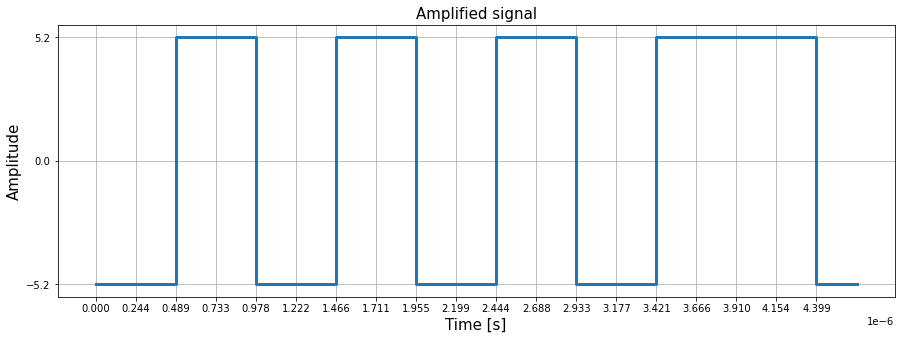

In [82]:
#COMPUTATION OF THE POWER OF THE SIGNAL
#At the moment the power of the signal is unitary, because each sample is either 1 or -1
#Therefore when we take the square of a sample we get 1, and if we sum them we get the length of the signal

def hpa(signal, time_vector, power_to_set):
    power = np.sum(signal**2)/len(signal)
    print("Power before amplification: ", power)
    
    #to set a different power P we just need to multiply the signal by the sqrt(P)
    amplified_signal = np.sqrt(power_to_set)*signal
    new_power = np.mean(amplified_signal**2)   #equivalent way to compute the power of a signal
    print("Power after amplification: ", new_power)
    
    #plot of the signal (first N samples)
    N = 20
    xticks = time_vector[0:N-1]
    yticks = [-np.sqrt(power_to_set), 0, np.sqrt(power_to_set)]
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(time_vector[0:N], amplified_signal[0:N], where='post', lw=3)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_title('Amplified signal', fontsize=15)
    ax.set_xlabel('Time [s]', fontsize=15)
    ax.set_ylabel('Amplitude', fontsize=15)
    ax.grid()
    
    return amplified_signal

signal_to_tx = hpa(modulated_sampled, t_sampled, settings['transmittedPower'])

## PROPAGATION THROUGH THE CHANNEL AND RECEIVED POWER

In order to simulate the propagation through the channel we need to consider the fact that the transmitted power $P_t$ will be highly attenuated. The formula to compute the received power is the following:

$P_r = P_t - P_L + G_t + G_r$  (dB)

where $P_t$ is the transmitted power, $P_L$ is the path loss, $G_t$ is the gain of the transmitting antenna and $G_r$ is the gain of the received antenna.

The path loss is provided by the orbital propagator group (as well as the other observables). Since the transmission of the signal corresponding to a packet lasts 0.32 seconds (the sampled modulated signal has a length of 1309440 samples and each sample has a duration of $\frac{T_c}{4} = 2.413 \dot 10^{-7}$ seconds) and in such a short time interval the FSPL remains almost constant, we decided to consider it as constant, keeping the first value of the FSPL for the whole transmission of the signal corresponding to a packet.
This is done to set the transmitting sample of the signal corresponding to a packet only once, at the beginning, in order to transmit a signal with a constant amplitude.

So, to simulate the signal at the receiver, we can compute the received power $P_r$, set the amplitude of the signal as $\sqrt{P_r}$ and introduce a delay computed by considering the code delays provided once again by the orbit propagator group. 

In [99]:
#simple function to convert from linear to dB
def lin2dB(x):
    return 10*np.log10(x)

#simple function to convert from dB to linear
def dB2lin(x):
    return 10**(x/10)

#here we load the file provided by the orbit propagator group
filename = "OrbitalDATA.txt"
orbit = pd.read_table(filename, header=0, sep=' ')
orbit = orbit.dropna(axis=0)

#we also want to consider the Free Space Path Loss in dB, so we add a column to the dataframe
orbit['FSPL[dB]'] = orbit['FSPL'].apply(lin2dB)

#in order to estimate also the propagation delay, we can just divide the pseudorange (satellite-user distance)
#by the speed of light. Therefore we create another column in the dataframe
c = 299792458   #speed of light in vacuum in m/s
orbit['PropDelay[s]'] = orbit['Pseudorange[m]']/c

#adding a column for the indexes
orbit['Index'] = np.arange(0, orbit.shape[0], 1)
column_list = ["Index","Date", "Time", "Siminstant[s]", "Pseudorange[m]", "FSPL", "CodeDelay[chips]", 
               "DopplerShift[Hz]", "FSPL[dB]", "PropDelay[s]"]
orbit = orbit.reindex(columns=column_list)

orbit

,Index,Date,Time,Siminstant[s],Pseudorange[m],FSPL,CodeDelay[chips],DopplerShift[Hz],FSPL[dB],PropDelay[s]
1,0,2022-06-01,09:10:37.830,4237.84,1.745497e+06,5.602320e+09,1864.260,3.45376,97.483679,0.005822
2,1,2022-06-01,09:10:37.840,4237.85,1.745486e+06,5.602250e+09,1864.230,3.45376,97.483625,0.005822
3,2,2022-06-01,09:10:37.850,4237.86,1.745476e+06,5.602190e+09,1864.190,3.45376,97.483578,0.005822
4,3,2022-06-01,09:10:37.860,4237.87,1.745466e+06,5.602120e+09,1864.160,3.45376,97.483524,0.005822
5,4,2022-06-01,09:10:37.870,4237.88,1.745456e+06,5.602060e+09,1864.130,3.45376,97.483478,0.005822
...,...,...,...,...,...,...,...,...,...,...
34337,34336,2022-06-01,09:16:21.190,4581.20,1.400148e+06,3.604770e+09,685.810,3.37927,95.568776,0.004670
34338,34337,2022-06-01,09:16:21.200,4581.21,1.400138e+06,3.604720e+09,685.776,3.37927,95.568715,0.004670
34339,34338,2022-06-01,09:16:21.210,4581.22,1.400128e+06,3.604670e+09,685.742,3.37926,95.568655,0.004670
34340,34339,2022-06-01,09:16:21.220,4581.23,1.400118e+06,3.604620e+09,685.708,3.37926,95.568595,0.004670


A typical value for the gain of the transmitting antenna is $G_t = 30$ dB (from lecture 17). The transmitted power was set to $P_t = 27$ W $= 14.3$ dBW $= 44.3$ dBm. We can also suppose that the gain of the receiving antenna is $G_r = 15$ dB. Therefore, by considering the FSPL inside the dataset, we can compute the received power.

In [100]:
#With these parameters, an example of received power is the following: as we can see, the received power is extremely
#low.

Pr_dB = 10*np.log10(settings["transmittedPower"]) - orbit['FSPL[dB]'][1] + settings["transmitterGain"] + settings["receiverGain"]
Pr = dB2lin(Pr_dB)  #this is in linear scale, so in Watt
print(Pr)

0.00015240381988987874


As already said many times, the signal associated to a packet is composed of 1309440 samples, and each sample has a duration of $T_s = \frac{T_c}{4} = 2.413 \cdot 10^{-7}$ seconds. Therefore the duration of the message associated to a packet is equal to $1309440 \cdot T_s = 0.316$ seconds. In the orbit dataframe the sampling period to compute the values of the observables is 10 ms, therefore 0.316 seconds (316 ms) corresponds to the first 316/10 = 31.6 $\approx$ 32 rows of the dataframe. 
In this short period of time the free space path loss and the propagation delay change in a trascurable way, as shown in the following cell.

In [106]:
print("FSPL of the first row: ", orbit['FSPL[dB]'][1])
print("FSPL of the 32th row: ", orbit['FSPL[dB]'][32])
print("Difference: ", np.abs(orbit['FSPL[dB]'][1] - orbit['FSPL[dB]'][32]))

print("\nPseudorange of the first row: ", orbit['PropDelay[s]'][1])
print("Pseudorange of the 32th row: ", orbit['PropDelay[s]'][32])
print("Difference: ", np.abs(orbit['PropDelay[s]'][1] - orbit['PropDelay[s]'][32]))

FSPL of the first row:  97.48367911746578
FSPL of the 32th row:  97.48211292158848
Difference:  0.0015661958773023343

Pseudorange of the first row:  0.005822349681892264
Pseudorange of the 32th row:  0.005821303087251114
Difference:  1.046594641149895e-06


Since the difference is negligible, in order to simplify the simulation we are going to consider a constant propagation delay and a constant FSPL for the transmission of each packet.

## I / Q SAMPLES AT THE RECEIVER

The modulated signal has been generated, and we can call it $s(t)$. The following step consists in generating the I/Q samples, that are simply obtained by multiplying the signal $s(t)$ by a cosine and a sine function:

$x_I(t) = s(t)\,\cos\,(2\,\pi\,f'\,t)$

$x_Q(t) = s(t)\,\sin\,(2\,\pi\,f'\,t)$

where $f'$ is a vector that contains all the Doppler frequencies computed during the process. This is because the I/Q samples are supposed to be generated in baseband, therefore there is no carrier frequency to consider in this case.

To generate the samples, we need of course to sample the signals $x_I(t)$ and $x_Q(t)$ and the sampling frequencies used in these cases are in the order of 4 or 5 MHz. A good choice might be to consider a sampling frequency $F_s = 4.092$ MHz (with a sampling period $T_s = \frac{1}{F_s} = 2.4438\,\cdot10^{-7} = \frac{T_c}{4}$ seconds).

This is a good choice because the signal $s\,(t)$ is composed of values spaced apart by $\frac{T_c}{2}$ seconds. By considering a sampling period of $\frac{T_c}{4}$ seconds we can sample the signal simply by considering two equal samples for each symbol in the signal $s(t)$.

Therefore, if for example we start from $s(t) = [-1, 1, -1 ...]$, after the process we are going to obtain $s(t) = [-1, -1, 1, 1, -1, -1 ...]$. Since, after the modulation, the length of $s(t)$ was 654720, after this process the length of $s(t)$ will be $654720\cdot2 = 1309440$ values.
Alternatively, we can also consider a sampling frequency $F_s = 8.184$ MHz (that refers to a sampling period $T_s = \frac{T_c}{8}$). In principle we can consider also bigger sampling frequencies, but energy and power consumption considerations must be also taken into account. Therefore we are going to use a sampling frequency $F_s = 4.092$ MHz (that correspond to $T_s = 2.4438\cdot10^{-7}$ seconds).

Regarding the Doppler frequencies, they are calculated by the orbit propagator group, and each value is referred to a new update of the satellite position. This is done with a sampling period that is way bigger than $\frac{T_c}{4}$, because the orbit parameters are typically updated less frequently. Therefore, in order to obtain a vector $f'$ with 1309440 values (to allow the multiplication of the cosine with $s(t))$, we need to interpolate the data provided by the other group.



### INTERPOLATION OF DOPPLER FREQUENCIES

In [ ]:
###############################################
#                                             #
#  CODE FOR INTERPOLATION MUST BE ADDED HERE  #
#                                             #
###############################################

#For the moment, since we don't have the data from the other group, we can just simulate the vector f'
final_length = 1309440
f_prime = np.zeros(final_length)
f_max = 3000

f_prime[0] = np.random.uniform(-f_max, f_max, 1)

#with the following for loop we generate doppler frequencies between -3 KHz and 3 KHz. The absolute value of 
#the differential doppler frequency between two consecutive symbols is not greater than 0.3 Hz (from Mattia).
for i in range(1,final_length):
        f_prime[i] = np.random.uniform(f_prime[i-1], f_prime[i-1] + 0.3, 1)
    
print(f_prime[0:20])
print("\nLength of the vector f':", len(f_prime))

In [ ]:
#so now we have the vector of Doppler frequencies, therefore we need to sample the signal s(t) (called "modulated"
#here) and to create the time vector t.
#As already said, each symbol of the vector s(t) has a duration of Tc / 2. Therefore if we use Ts = Tc / 4 we
#just need to repeat each symbol of s(t) two times. This can be easily done with the function np.repeat()


# ALREADY DONE AFTER THE MODULATION


# Fs = 4.092e06    #sampling frequency is 4.092 MHz
# Ts = 1 / Fs      #sampling period, equal to Tc/4

# #creation of the sampled signal
# modulated_sampled = np.repeat(modulated, 2)
# print("Before sampling:", modulated[0:9])
# print("After sampling", modulated_sampled[0:18])
# print("Length after sampling:", len(modulated_sampled))

# #creation of the time vector
# t_sampled = np.arange(0, final_length * Ts, Ts)   #1309440 values spaced apart by Tc / 4 seconds each
# print("\nTime vector:", t_sampled)
# print("Time vector length:", len(t_sampled))

Now all the vectors have the right length, and we can obtain $x_I(t)$ and $x_Q(t)$, and we can also add the noise using the awgn function defined here.

In [ ]:
#This function simulates the additive white gaussian noise channel. It takes as input the signal without the noise,
#the power of the noise in dB and a flag that allows the generation of the noise only if it is true.

def awgn(s, noise_power_dB, flag):
    length = len(s)
    if flag == True:
        noise = 10 ** (noise_power_dB/20) * np.random.randn(length)  
        #this returns gaussian samples drawn from the standard normal distribution, so with zero mean and unitary
        #variance. The zero mean is okay, but the variance of the noise should be equal to its power, so we need
        #to multiply by the standard deviation of the noise (that is the sqrt of the power, so the sqrt of
        #(10**noise_power_dB/10). That is why we put the multiplication factor there.
        s = s + noise
    return s

In [ ]:
t_sampled = np.arange(0, final_length * Ts, Ts) #1309440 values spaced apart by Tc / 4 seconds each 
                                                #last value is 0.32 seconds
t_sampled2 = np.arange(t_sampled[-1], 2*final_length * Ts, Ts)
print("\n", t_sampled2)
print(len(t_sampled2))
# print(final_length)

In [ ]:
I = modulated_sampled*np.cos(2*pi*f_prime*t_sampled) 
print("\nI:", I[0:20])

#addition of noise 
I_noise = awgn(I, -30, True)
print("\n\nAfter noise addition on I:\n", I_noise[0:20])

Q = modulated_sampled*np.sin(2*pi*f_prime*t_sampled)
print("\nQ:", Q[0:20])

#addition of noise (noise power = -50 dB): THIS VALUE MUST BE CHECKED, NO IDEA ABOUT NOISE POWER TYPICAL VALUES
Q_noise = awgn(Q, -50, True)
print("\n\nAfter noise addition on Q:\n", Q_noise[0:20])

#some plots (first N samples)
N = 30

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
xticks = t_sampled[0:N]
ax.stem(t_sampled[0:N], I[0:N])
ax.set_xticks(xticks)
plt.xticks(rotation=45)
ax.set_title("I samples before noise addition", fontsize=15)
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_ylabel("I samples", fontsize=15)
ax.grid()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
xticks = t_sampled[0:N]
ax.stem(t_sampled[0:N], I_noise[0:N])
ax.set_xticks(xticks)
plt.xticks(rotation=45)
ax.set_title("I samples after noise addition", fontsize=15)
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_ylabel("I samples", fontsize=15)
ax.grid()

## QUANTIZATION

Before writing the I/Q samples of the modulated signal in a binary file, we need to quantize them. In order to do that, we consider a uniform quantization with 8 bits, therefore we divide the interval of amplitudes between -1 and 1 in $2^8$ = 256 levels, equally spaced apart between each other.
Each sample will be substituted by the value of the level that is closest to it.
The function **quantization** takes as input the array to quantize, the upper and lower bounds of the interval from which the levels are drawn, the number of bits for the quantization and a flag that, if true, prints the set of levels of the quantization.

In [ ]:
def quantization(array, upper_bound, lower_bound, n_bits, flag):
    n_levels = 2**n_bits
    step = (upper_bound - lower_bound)/n_levels
    
    #creating the set of values for the quantization
    values_set = np.zeros(n_levels)
    values_set[0] = lower_bound
    for i in range(1, n_levels):
        values_set[i] = values_set[i-1]+step
    
    if(flag==True):
        print(values_set)
        
    #quantizing the noisy I/Q samples
    quantized = np.zeros(len(array))
    for i in range(len(array)):
        #find the index that provides the minimum difference between the sample and the elements inside the set
        index = (np.abs(values_set - array[i])).argmin() 
        quantized[i] = values_set[index]
    
    return quantized

I_quantized = quantization(I_noise, 1, -1, 8, True)
print("\nI_noise: ", I_noise[0:10] )
print("\nI_quantized", I_quantized[0:10])        
    
Q_quantized = quantization(Q_noise, 1, -1, 8, False)
print("\nQ_noise: ", Q_noise[0:10] )
print("\nQ_quantized", Q_quantized[0:10])        

# print(len(Q_quantized))
# print(len(Q_noise))